In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.linear_model import LogisticRegression as LR
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from time import time
import datetime

In [3]:
def plot_learning_curve(estimator, title, X, y,
                        ax,  #选择子图
                        ylim=None,  #设置纵坐标的取值范围
                        cv=None,  #交叉验证
                        n_jobs=None  #设定索要使用的线程
                        ):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y
                                                            , cv=cv, n_jobs=n_jobs)
    ax.set_title(title)
    if ylim is not None:
        ax.set_ylim(*ylim)
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")
    ax.grid()  #显示网格作为背景，不是必须
    ax.plot(train_sizes, np.mean(train_scores, axis=1), 'o-'
            , color="r", label="Training score")
    ax.plot(train_sizes, np.mean(test_scores, axis=1), 'o-'
            , color="g", label="Test score")
    ax.legend(loc="best")
    return ax

In [4]:
digits = load_digits()
X, y = digits.data, digits.target

In [9]:
from sklearn.model_selection import train_test_split
Xtrain,Xtest,Ytrain,Ytest = train_test_split(X,y,test_size=0.3,random_state=420)

In [10]:
gnb = GaussianNB().fit(Xtrain,Ytrain)

In [11]:
prob = gnb.predict_proba(Xtest)

In [5]:
X.shape

(1797, 64)

In [6]:
X  #是一个稀疏矩阵

array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  6.,  0.,  0.],
       [ 0.,  0.,  2., ..., 12.,  0.,  0.],
       [ 0.,  0., 10., ..., 12.,  1.,  0.]])

In [7]:
title = ["Naive Bayes", "DecisionTree", "SVM, RBF kernel", "RandomForest", "Logistic"]
model = [GaussianNB(), DTC(), SVC(gamma=0.001)
    , RFC(n_estimators=50), LR(C=.1, solver="lbfgs")]
cv = ShuffleSplit(n_splits=50,  # 把数据分成多少份
                  test_size=0.2,  # 20%*50份的数据会被作为测试集
                  random_state=0  # 分交叉验证的份数的时候进行的随机抽样的模式
                  )

Naive Bayes:00:02:179422
DecisionTree:00:01:130165
SVM, RBF kernel:00:07:276549
RandomForest:00:10:804084
Logistic:00:04:051592


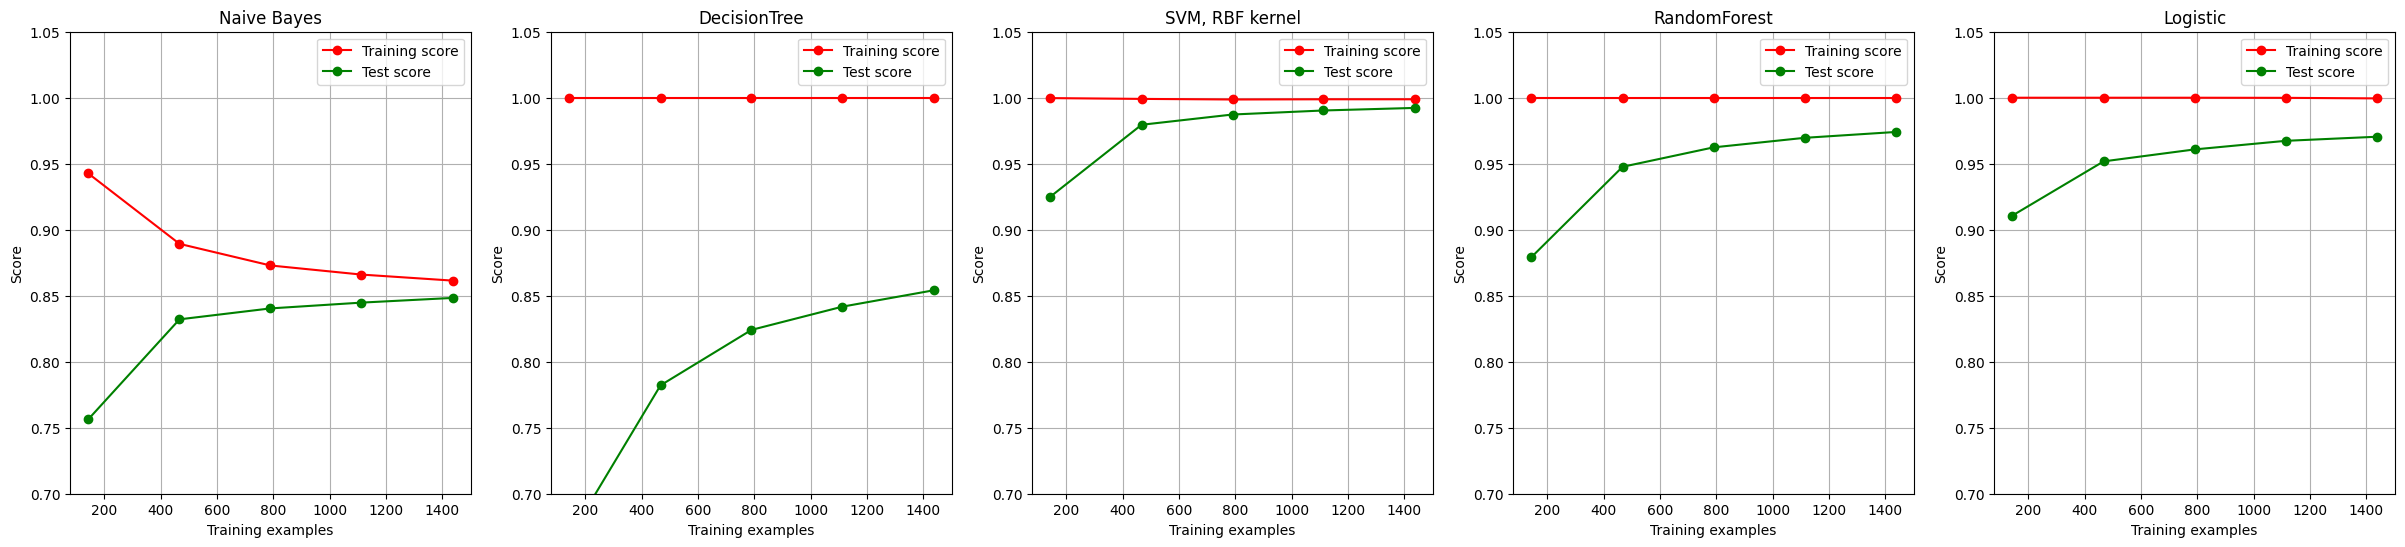

In [8]:
fig, axes = plt.subplots(1,5,figsize=(30,6))
for ind,title_,estimator in zip(range(len(title)),title,model):
    times = time()
    plot_learning_curve(estimator, title_, X, y,
                        ax=axes[ind], ylim = [0.7, 1.05],n_jobs=4, cv=cv)
    print("{}:{}".format(title_,datetime.datetime.fromtimestamp(time()-
times).strftime("%M:%S:%f")))
plt.show()

In [15]:
from sklearn.metrics import brier_score_loss
import pandas as pd
#注意，第一个参数是真实标签，第二个参数是预测出的概率值
#在二分类情况下，接口predict_proba会返回两列，但SVC的接口decision_function却只会返回一列
#要随时注意，使用了怎样的概率分类器，以辨别查找置信度的接口，以及这些接口的结构
Ytest_ = Ytest.copy()
Ytest_ = pd.get_dummies(Ytest_)
brier_score_loss(Ytest_[1], prob[:,1])
#我们的pos_label与prob中的索引一致，就可以查看这个类别下的布里尔分数是多少

0.032619662406118764

In [16]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression as LR

In [17]:
logi = LR(C=1., solver='lbfgs',max_iter=3000,multi_class="auto").fit(Xtrain,Ytrain)
svc = SVC(kernel = "linear",gamma=1).fit(Xtrain,Ytrain)

D:\IDE\Anaconda\A\envs\dproject\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [18]:
brier_score_loss(Ytest_[1],logi.predict_proba(Xtest)[:,1])

0.011415109262886945

In [19]:
#由于SVC的置信度并不是概率，为了可比性，我们需要将SVC的置信度“距离”归一化，压缩到[0,1]之间
svc_prob = (svc.decision_function(Xtest) -
svc.decision_function(Xtest).min())/(svc.decision_function(Xtest).max() -
svc.decision_function(Xtest).min())

In [22]:
brier_score_loss(Ytest_[1],svc_prob[:,1])

0.24286480465579566

In [26]:
import pandas as pd
name = ["Bayes","Logistic","SVC"]
color = ["red","black","orange"]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


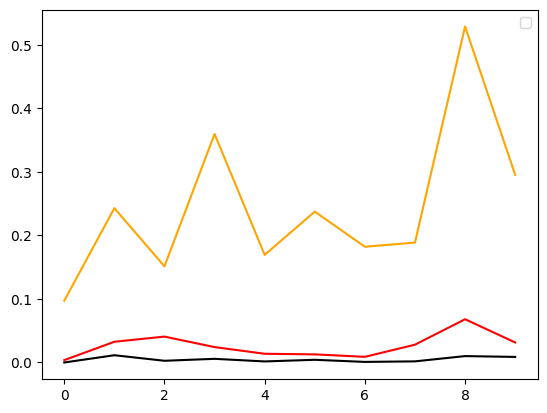

In [27]:
df = pd.DataFrame(index=range(10),columns=name)
for i in range(10):
    df.loc[i,name[0]] = brier_score_loss(Ytest_[i],prob[:,i])
    df.loc[i,name[1]] = brier_score_loss(Ytest_[i],logi.predict_proba(Xtest)
[:,i])
    df.loc[i,name[2]] = brier_score_loss(Ytest_[i],svc_prob[:,i])
for i in range(df.shape[1]):
    plt.plot(range(10),df.iloc[:,i],c=color[i])
plt.legend()
plt.show()

In [25]:
df

,Bayes,Logistic,SVC
0,0.003681,0.000011,0.097285
1,0.03262,0.011415,0.242865
2,0.040738,0.002689,0.151375
3,0.024227,0.005754,0.359645
4,0.013717,0.001658,0.169369
5,0.012771,0.004236,0.237454
6,0.008907,0.000912,0.182166
7,0.028007,0.001763,0.188718
8,0.068071,0.01006,0.528845
9,0.031525,0.008764,0.295335


In [28]:
from sklearn.metrics import log_loss

In [29]:
log_loss(Ytest,prob)

2.5352864353201885

In [30]:
log_loss(Ytest,logi.predict_proba(Xtest))

0.12722680314758886

In [31]:
log_loss(Ytest,svc_prob)

1.6074987533411256